### Visualising DC clusters only (re-doing from pre-hvg onwards instead of just re-mapping before calculating DEGs)
### Using bbknn for batch correction instead of harmony

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce
from matplotlib.pyplot import rc_context
import seaborn as sns

In [2]:
#set current directory 
os.chdir('/scratch/user/s4436039/scdata/Myeloid_Objects')
os.getcwd()

'/scratch/user/s4436039/scdata/Myeloid_Objects'

In [5]:
# read in data
data_labels = sc.read_h5ad('NRclean_clustered2_DC.h5ad')
data_clean_prehvg = sc.read_h5ad('NR_cleandata.h5ad')

In [6]:
data_labels

AnnData object with n_obs × n_vars = 30241 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_annotatio

In [7]:
data_clean_prehvg

AnnData object with n_obs × n_vars = 498382 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [8]:
#subset data_clean_prehvg to only the cells in data_labels based on barcode

# Get the list of barcodes (cell names) in data_labels
barcodes_to_keep = data_labels.obs.index

# subset data_clean_prehvg to just those in data_labels
data_clean_prehvg2 = data_clean_prehvg[data_clean_prehvg.obs.index.isin(barcodes_to_keep), :]

data_clean_prehvg2

View of AnnData object with n_obs × n_vars = 30241 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [9]:
# transfer metadata from final atlas (data_labels) to clean data pre-hvg (want pre-hvg data so I can re-do hvg calculation on just DC2)

#define columns to transfer
meta_columns = ['Technology','NR_annotations_simple','sample_type_major2','cancer_with_H','cancer_broadest','patient_treatment']

# Subset the metadata in data_labels to match data_clean_prehvg2's barcodes
metadata_to_transfer = data_labels.obs.loc[data_clean_prehvg2.obs.index, meta_columns]

# Add these columns to data_clean_prehvg2's obs
for col in meta_columns:
    data_clean_prehvg2.obs[col] = metadata_to_transfer[col]

# Verify that the metadata was transferred
data_clean_prehvg2.obs.tail()

/scratch/temp/14490072/ipykernel_2867082/846974978.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


,nCount_RNA,nFeature_RNA,sample_type,cancer_type,patient_id,sample_id,percent.mt,site,sample_type_major,cancer_subtype,...,leiden_DC,leiden_DC_v2,exclude_annots,leiden_M,Technology,NR_annotations_simple,sample_type_major2,cancer_with_H,cancer_broadest,patient_treatment
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_GTTTACTCAAGGCCTC,-9.995153,-8.131683,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,2694.0,ovary,primary tumour,HGSOC,...,4,1,NA,NaN,10x3',cDC1,primary tumour,HGSOC,HGSOC,Treatment naive
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TACCGAACAAACCGGA,-9.134331,-8.627023,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,839.0,ovary,primary tumour,HGSOC,...,2,4,NA,NaN,10x3',cDC2,primary tumour,HGSOC,HGSOC,Treatment naive
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TCACGCTTCCGTCACT,-10.033317,-7.518040,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,1683.0,ovary,primary tumour,HGSOC,...,3,2,NA,NaN,10x3',mregDC,primary tumour,HGSOC,HGSOC,Treatment naive
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TGCAGTAGTGTTGCCG,-9.364501,-8.566583,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,2257.0,ovary,primary tumour,HGSOC,...,5,15,NA,NaN,10x3',cDC2,primary tumour,HGSOC,HGSOC,Treatment naive
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TGTGAGTTCGGAAACG,-9.738727,-7.459797,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,949.0,ovary,primary tumour,HGSOC,...,3,2,NA,NaN,10x3',mregDC,primary tumour,HGSOC,HGSOC,Treatment naive


In [10]:
data_labels.obs["NR_annotations_simple"].value_counts()

NR_annotations_simple
cDC2      17391
cDC1       6730
mregDC     6120
Name: count, dtype: int64

In [11]:
# check
data_clean_prehvg2.obs["NR_annotations_simple"].value_counts()

NR_annotations_simple
cDC2      17391
cDC1       6730
mregDC     6120
Name: count, dtype: int64

In [12]:
# rename to data
data = data_clean_prehvg2

In [13]:
# check
data.obs["NR_annotations_simple"].value_counts()

NR_annotations_simple
cDC2      17391
cDC1       6730
mregDC     6120
Name: count, dtype: int64

# Filtering:

In [14]:
# remove any samples with less than 10 cells
data = data[data.obs['integration_id'].map(data.obs['integration_id'].value_counts()) >= 10].copy()

In [15]:
# remove any genes expressed in less than 10 cells
sc.pp.filter_genes(data, min_cells=10)

In [16]:
data

AnnData object with n_obs × n_vars = 29887 × 14529
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'

# pre-hvg to integration on new DC2 only object:

In [17]:
# identify highly variable genes
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
data

AnnData object with n_obs × n_vars = 29887 × 14529
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [18]:
#set hidden slot
data.raw = data

In [19]:
#to get number of HV genes
print(data.var.highly_variable.sum())

1746


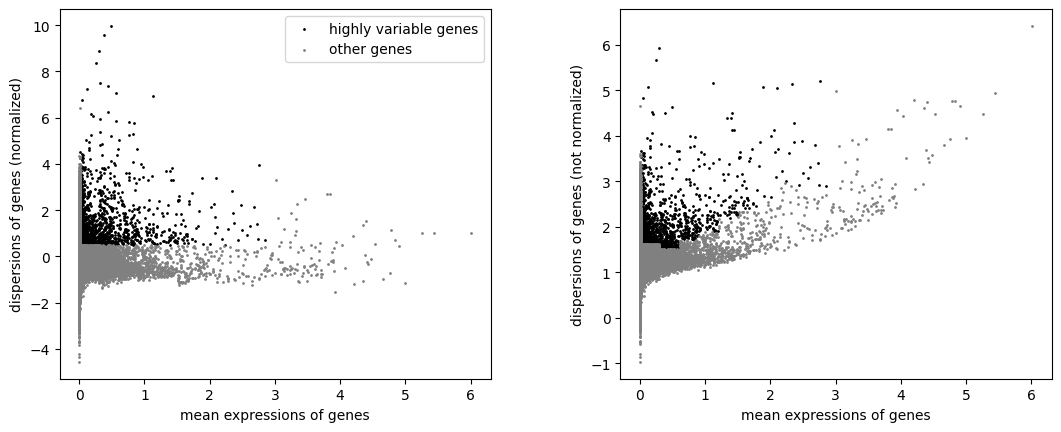

In [20]:
#plot out the number of highly variable genes
sc.pl.highly_variable_genes(data)

### regress out factors and perform scaling

In [21]:
# Actually do the filtering for PCA
data = data[
    :, data.var.highly_variable
].copy()  # all rows/indexes : columns only selecting for those within high_variable, and then making a copy of itself
data

AnnData object with n_obs × n_vars = 29887 × 1746
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [22]:
#Regress out total counts, %mt, cycling genes (30sec)
sc.pp.regress_out(data, ["total_counts", "pct_counts_mt", 'S_score', 'G2M_score'])
sc.pp.scale(data, max_value=10)

In [23]:
data

AnnData object with n_obs × n_vars = 29887 × 1746
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'l

### Perform PCA:

In [24]:
## perform PCA, adjust number of PCs to calculate. (1mins)
sc.pp.pca(data, n_comps=50)

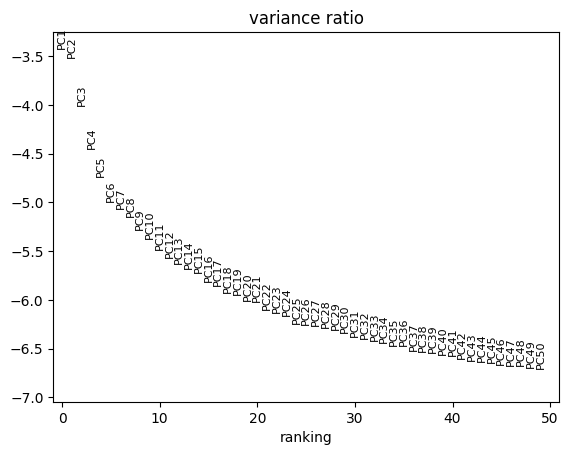

In [25]:
# make elbow plot to see variance contribution by each pc, choose inflection point
sc.pl.pca_variance_ratio(data, log=True, n_pcs=50)

### BBKNN Integration: 

In [26]:
sce.pp.bbknn(data, batch_key='integration_id')  

In [27]:
data.obsm

AxisArrays with keys: X_pca

#### No longer need neighbors step (bbknn replaces this)

### UMAP:

In [28]:
sc.tl.umap(data, min_dist=0.3) 

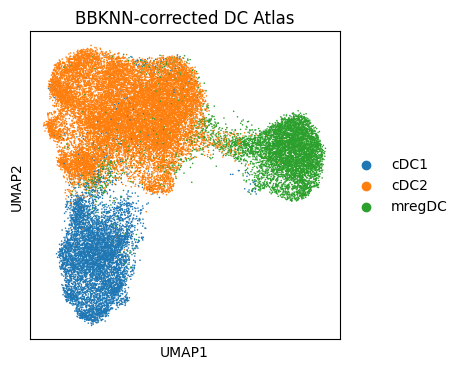

In [29]:
#plotting DC map
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=["NR_annotations_simple"], ncols=1, size=5, title='BBKNN-corrected DC Atlas')

In [30]:
custom_palette = [
    "#C53A32",  # cDC1
    "#9E47F3",  # cDC2
    "#84594F",  # mregDC
]

In [31]:
sc.set_figure_params(dpi=100, dpi_save=700, vector_friendly=True, format='svg')

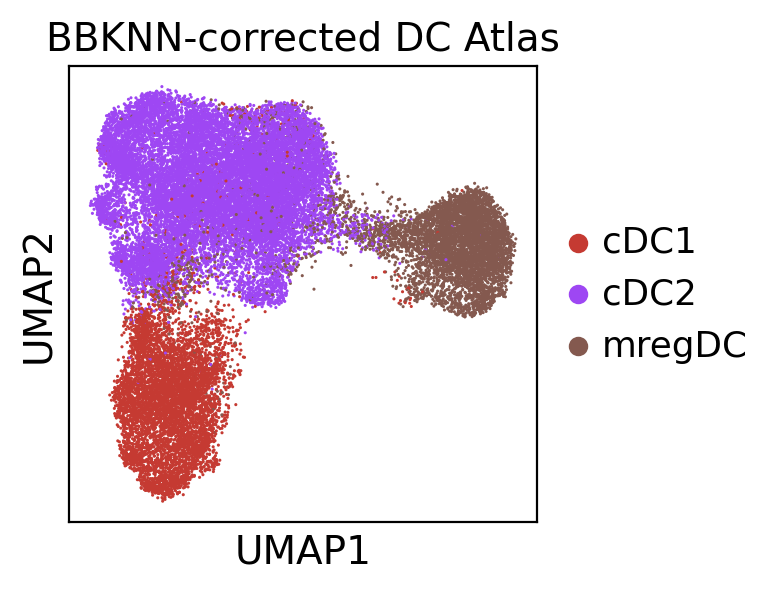

In [32]:
#plotting DC map
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(data, color=["NR_annotations_simple"], ncols=1, size=5, title='BBKNN-corrected DC Atlas', palette=custom_palette)

# Harmony Integration:

In [46]:
sce.pp.harmony_integrate(data, 'integration_id', max_iter_harmony=200, verbose=True)

2025-06-16 16:23:15,306 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-16 16:23:19,807 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-16 16:23:20,032 - harmonypy - INFO - Iteration 1 of 200
2025-06-16 16:24:55,256 - harmonypy - INFO - Iteration 2 of 200
2025-06-16 16:26:30,405 - harmonypy - INFO - Iteration 3 of 200
2025-06-16 16:27:59,866 - harmonypy - INFO - Iteration 4 of 200
2025-06-16 16:29:25,132 - harmonypy - INFO - Iteration 5 of 200
2025-06-16 16:30:51,110 - harmonypy - INFO - Iteration 6 of 200
2025-06-16 16:32:10,669 - harmonypy - INFO - Iteration 7 of 200
2025-06-16 16:33:35,932 - harmonypy - INFO - Iteration 8 of 200
2025-06-16 16:34:54,371 - harmonypy - INFO - Iteration 9 of 200
2025-06-16 16:36:11,601 - harmonypy - INFO - Iteration 10 of 200
2025-06-16 16:37:28,917 - harmonypy - INFO - Iteration 11 of 200
2025-06-16 16:38:46,053 - harmonypy - INFO - Converged after 11 iterations


In [47]:
data.obsm

AxisArrays with keys: X_pca, X_pca_harmony

In [48]:
#check made new column with adjusted harmony PCs
'X_pca_harmony' in data.obsm

True

In [49]:
#assign the new PCs to the standard PCA slot for post int
data.obsm['X_pca'] = data.obsm['X_pca_harmony']

In [51]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(data, n_neighbors=10, n_pcs=50)

In [52]:
sc.tl.umap(data, min_dist=0.3)  # 0.3 is personal preference

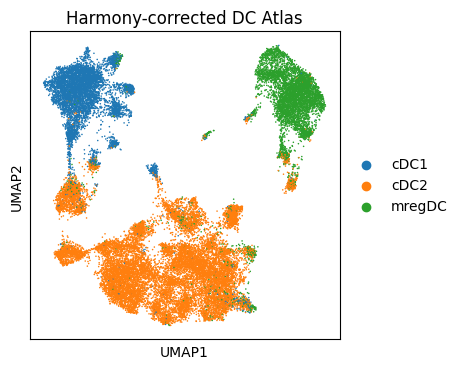

In [53]:
#plotting DC map
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=["NR_annotations_simple"], ncols=1, size=5, title='Harmony-corrected DC Atlas')

## When data is subsetted (to all DC or cDC2) Harmony seems to granulate the data, therefore, using bbknn for visualisation

# Using bbknn map:

### Overlay gene sets:

In [33]:
#define DC subset gene sets from Villani et al 
DC1_sig = ['CLEC9A','C1ORF54','HLA-DPA1','CADM1','CAMK2D','CPVL','HLA-DPB2','WDFY4','CPNE3','IDO1','HLA-DPB1','LOC645638','HLA-DOB','HLA-DQB1','HLA-DQB','CLNK','CSRP1','SNX3','ZNF366','KIAA1598','NDRG2','ENPP1','RGS10','AX747832','CYB5R3','ID2','XCR1','FAM190A','ASAP1','SLAMF8','CD59','DHRS3','GCET2','FNBP1','TMEM14A','NET1','BTLA','BCL6','FLT3','ADAM28','SLAMF7','BATF3','LGALS2','VAC14','PPA1','APOL3','C1ORF21','CCND1','ANPEP','ELOVL5','NCALD','ACTN1','PIK3CB','HAVCR2','GYPC','TLR10','ASB2','KIF16B','LRRC18','DST','DENND1B','DNASE1L3','SLC24A4','VAV3','THBD','NAV1','GSTM4','TRERF1','B3GNT7','LACC1','LMNA','PTK2','IDO2','MTERFD3','CD93','DPP4','SLC9A9','FCRL6','PDLIM7','CYP2E1','PDE4DIP','LIMA1','CTTNBP2NL','PPM1M','OSBPL3','PLCD1','CD38','EHD4','ACSS2','LOC541471','FUCA1','SNX22','APOL1','DUSP10','FAM160A2','INF2','DUSP2','PALM2','RAB11FIP4','DSE','FAM135A','KCNK6','PPM1H','PAFAH1B3','PDLIM1','TGM2','SCARF1','CD40','STX3','WHAMMP3','PRELID2','PQLC2']
DC2_sig = ['CD1C','FCER1A','CLEC10A','ADAM8','CD1D','FCGR2B','CLEC4A','SLC2A3','CD33','ETS2','CLIC2','PEA15','CACNA2D3','CD1E','MBOAT7','C10ORF128','NR4A2','AGPAT9','ENTPD1','CD2','PER1','PID1','AREG','PTGS1','SMA','CLEC17A','ITGA5','CREB5','PTAFR','NOD2','CCR6']
DC3_sig = ['S100A9','S100A8','VCAN','LYZ','ANXA1','PLBD1','RNASE2','FCER1A','SLC2A3','CD163','CSF3R','MNDA','CD14','NAIP','CSTA','FCN1','CD1D','FPR1','F13A1','CLEC10A','CES1','PID1','S100A12','MTMR11','SMA','LAT2','RETN','TMEM173','AOAH','RAB3D','CD36','MGST1','TREM1','HNMT','CES1P1','ADAM15','IL13RA1','MICAL2','ITGA5','CREB5','IL1B','NR4A2','MPP7','PTAFR','HBEGF','NFE2','ASGR1','BST1','IL1RN','NOD2','NLRP3','DQ575504','LMNA','C9ORF89','IL27RA','NLRP12','RAB27A','EREG','LOC284454']

#mregDC sig from Merad
mregDC_sig = ['CD40','CD80','CD86','RELB','CD83','CD274','PDCD1LG2','CD200','FAS','ALDH1A2','SOCS1','SOCS2','CCR7','MYO1G','CXCL16','ADAM8','ICAM1','FSCN1','MARCKS','MARCKSL1','IL4RA','IL4I1','CCL17','CCL22','TNFRSF4','STAT6','BCL2L1']

In [34]:
# Define dictionary of gene sets
gene_sets = {
    "DC1_sig": DC1_sig,
    "DC2_sig": DC2_sig,
    "DC3_sig": DC3_sig,
    "mregDC_sig": mregDC_sig
}

In [35]:
# Loop through each gene set and calculate the scores
for name, genes in gene_sets.items():
    sc.tl.score_genes(data, genes, score_name=name)

       'FAM190A', 'GCET2', 'C1ORF21', 'LRRC18', 'MTERFD3', 'LOC541471',
       'PALM2', 'WHAMMP3', 'PQLC2'],
      dtype='object')


In [36]:
colour_vars = ["DC1_sig","DC2_sig","DC3_sig","mregDC_sig","NR_annotations_simple"]

In [37]:
titles=['cDC1 Score (Villani et al. 2017)','cDC2 Score (Villani et al. 2017)','DC3 Score (Villani et al. 2017)', 'mregDC Score (Maier et al. 2020)', 'DC Annotations']

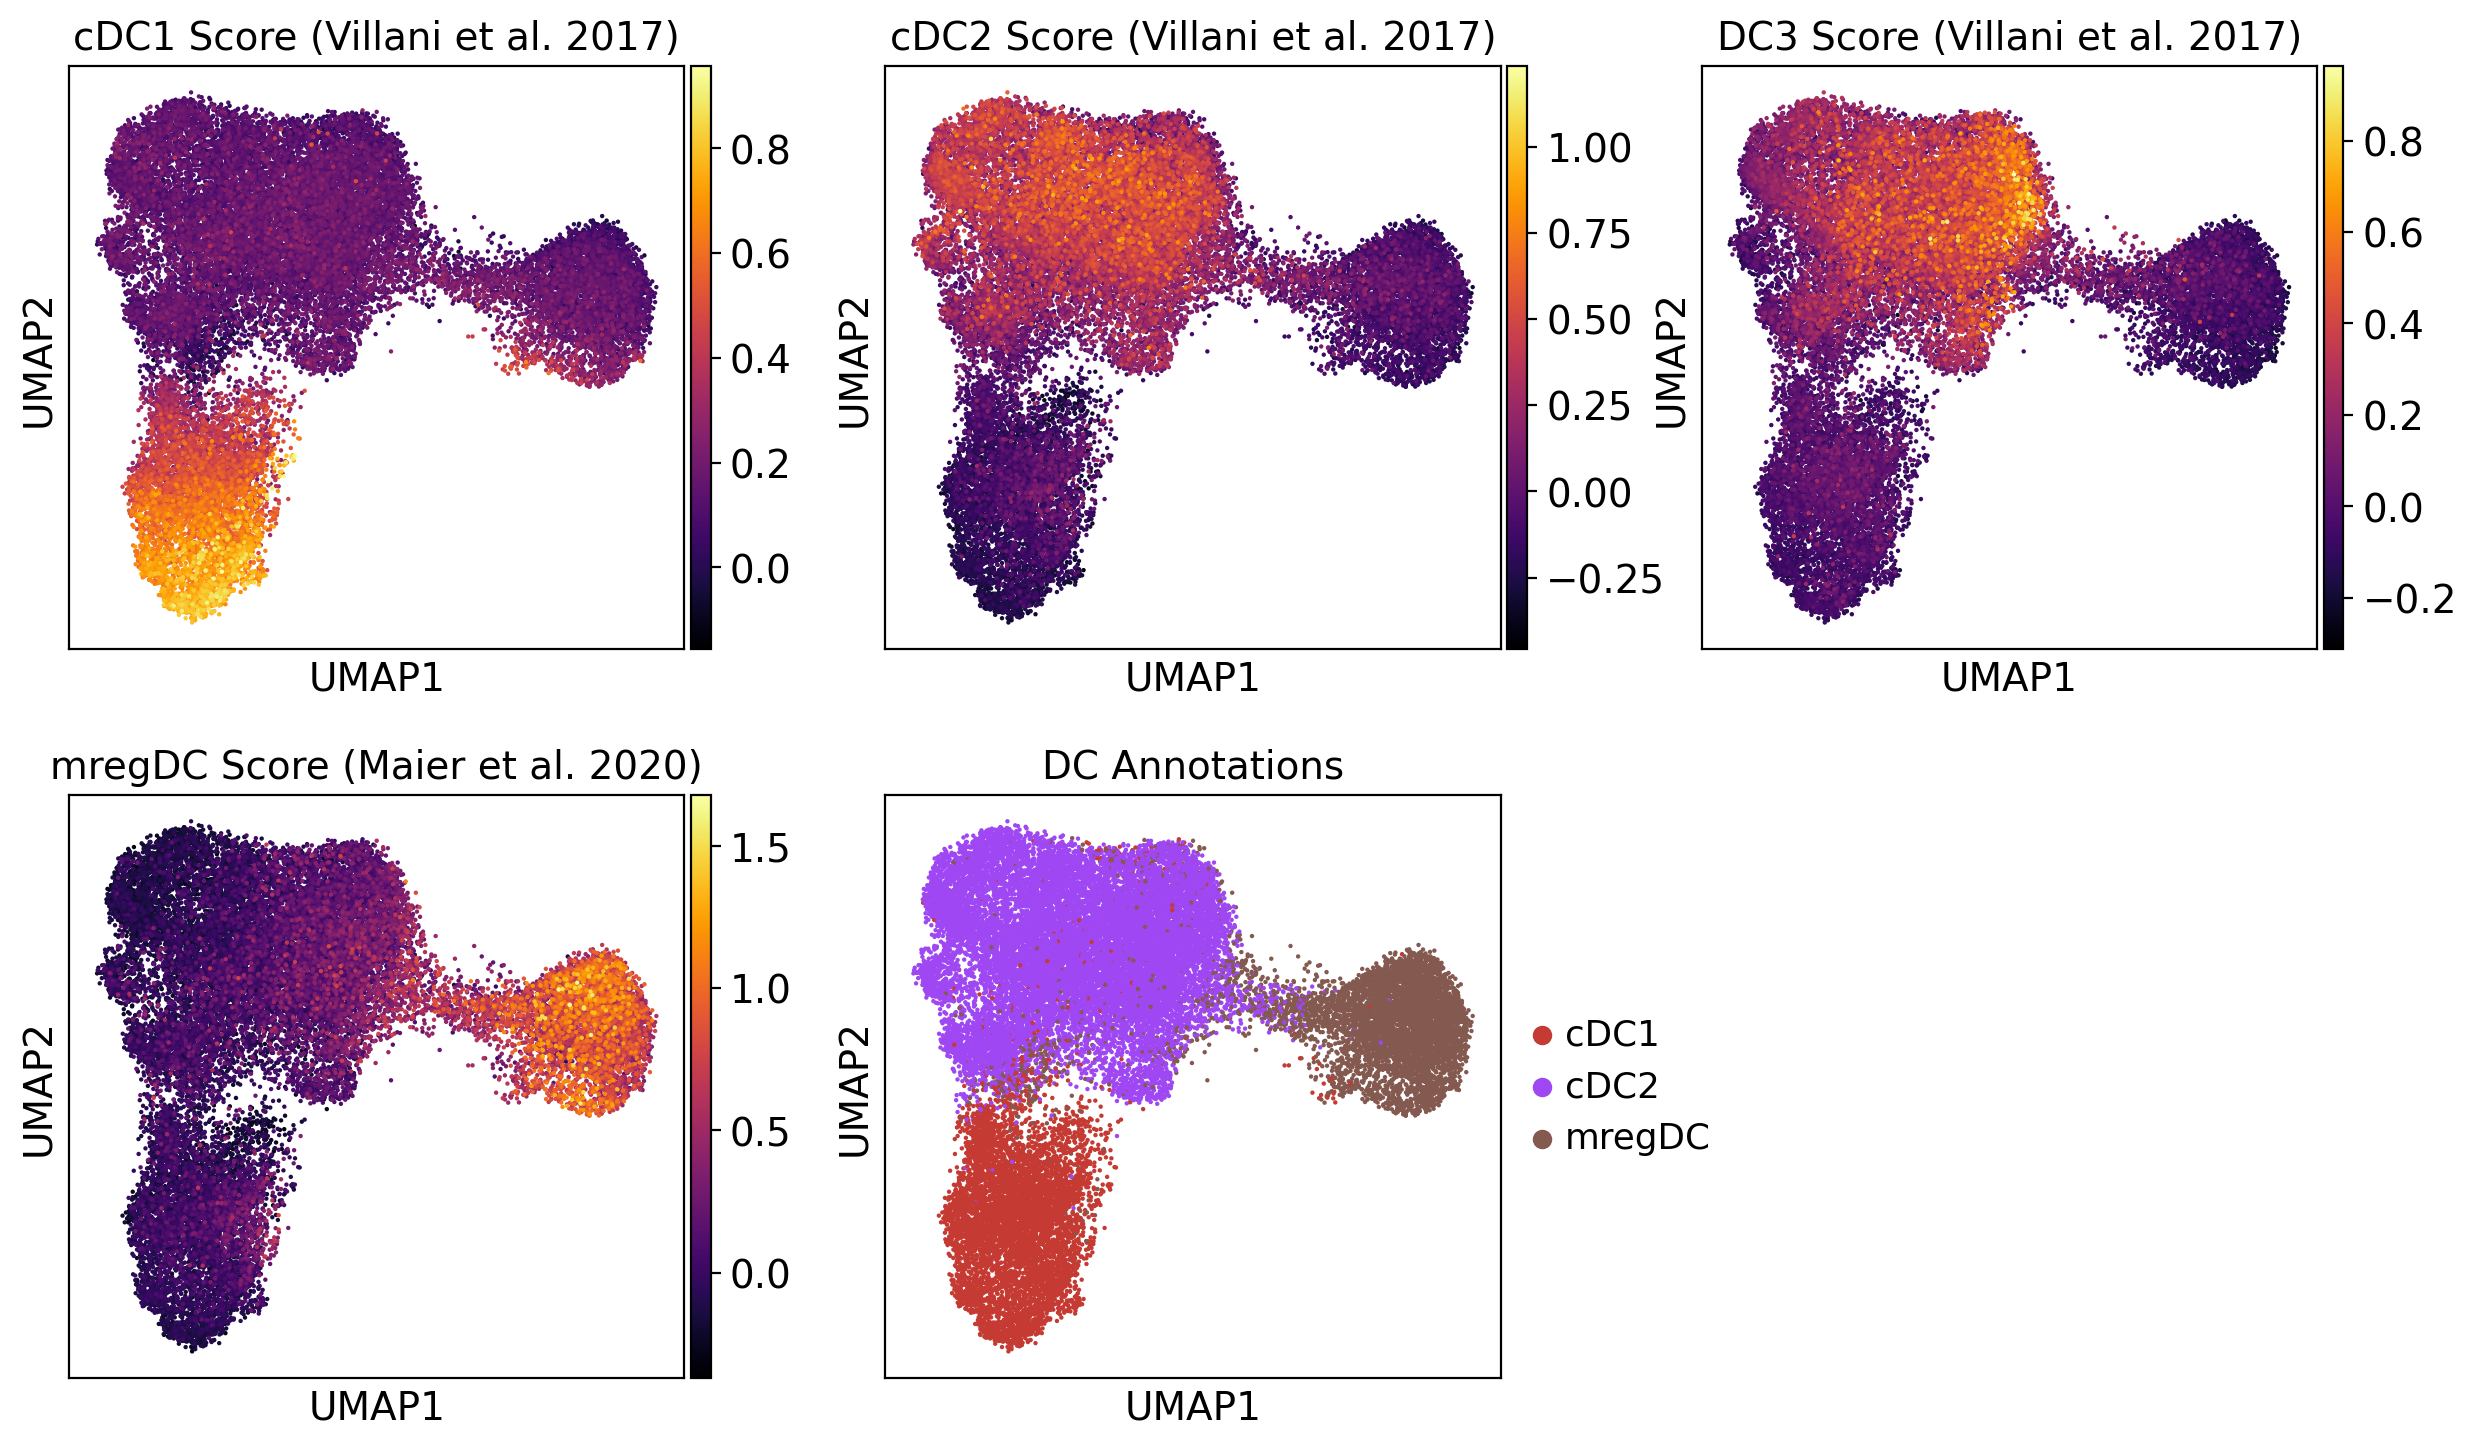

In [38]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=colour_vars, ncols=3, size=10, title=titles, cmap='inferno', palette=custom_palette, save="_DC-only_Clusters_Overlay.svg")

In [39]:
#calculate DEG genes:
sc.tl.rank_genes_groups(data, groupby="NR_annotations_simple", method="wilcoxon")

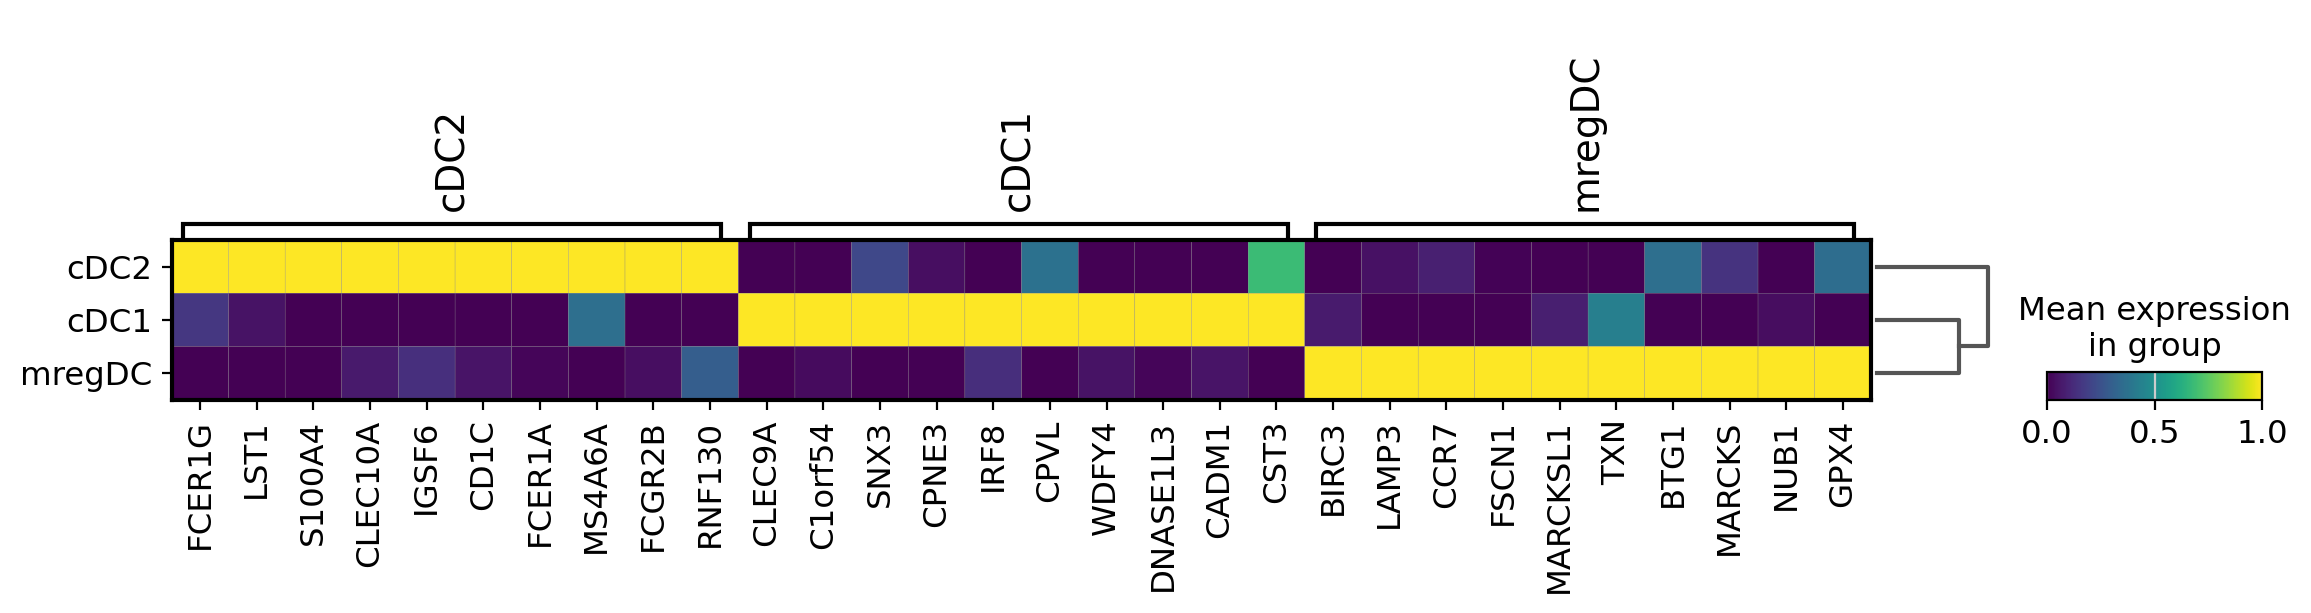

In [40]:
# visualise the top 10 DEG genes
sc.tl.dendrogram(data, groupby="NR_annotations_simple")
sc.pl.rank_genes_groups_matrixplot(data, groupby="NR_annotations_simple", standard_scale="var", n_genes=10, min_logfoldchange=1, save="_DC-only_DEGS.svg")

In [42]:
# export object: 
data.write_h5ad("20250617_AllDC_bbknn.h5ad", compression="gzip")

# Check if CD207/CD1A higher in DC in melanoma

In [3]:
# read in data
data = sc.read_h5ad('20250617_AllDC_bbknn.h5ad')

In [4]:
#subset to primary samples
data_P = data[data.obs["sample_type_major2"].isin(["primary tumour"])]

In [5]:
#define DC subset gene sets from Villani et al 
LC_sig = ['CD207','CD1A']

In [6]:
# Define dictionary of gene sets
gene_sets = {
    "LC_score": LC_sig,
}

In [7]:
# Loop through each gene set and calculate the scores
for name, genes in gene_sets.items():
    sc.tl.score_genes(data_P, genes, score_name=name)

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [8]:
# extract data
df = data_P.obs[["LC_score", "NR_annotations_simple", "cancer_broadest"]].copy()

In [9]:
# calculate mean LC_score
heatmap_df = (
    df.groupby(["NR_annotations_simple", "cancer_broadest"])["LC_score"]
    .mean()
    .unstack()  # makes cancer_broadest columns, NR_annotations_simple rows
)

/scratch/temp/14490072/ipykernel_2970685/3801329236.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


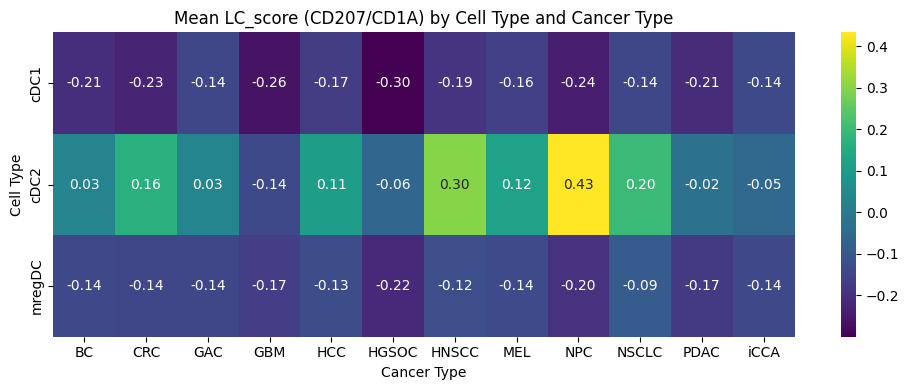

In [10]:
# plot
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_df, cmap="viridis", annot=True, fmt=".2f", cbar=True)

plt.title("Mean LC_score (CD207/CD1A) by Cell Type and Cancer Type")
plt.xlabel("Cancer Type")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()